# Mechanisms of Lift: QG, Residual, Orographic

In [10]:
import xarray as xr 
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys
#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
from scipy.ndimage import gaussian_filter

from metpy.interpolate import cross_section
import metpy.calc as mpcalc
from scipy import stats
from metpy.calc import lat_lon_grid_deltas, first_derivative

## Centered Composites

### 1. calculate orographic lift with orographic_lift.py
### 2. calculate QG omega and residual with Omega_Inversion.py


In [11]:
r = 1
lev = 700
lift_estimates = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Omega_new/new_extendlon_700_orographic_omega_spatial_Region'+str(r)+'.nc').Orographic_Lift.load()
                         
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
color_map = [ '#01004C','#0A006E','#0A006E', '#1800B6','#1800B6', '#2600FF', '#2600FF', '#6565FF','#6565FF', '#ACACFF','#ACACFF', '#DADAFF','#DADAFF', '#FFFFFF','#FFFFFF','#FFCBCB','#FFCBCB',  '#FF9192','#FF9192','#FF6564','#FF6564', '#FF0300','#FF0300', '#CC0200','#CC0200', '#980000', '#980000', '#7E0100', '#7E0100']

extend_slice_start = [-72,  0,  72,  144, -144]
extend_slice_end = [ 71.5, 144, 216, 288,  -.5]
slice_start = np.array([-36, 36, 108, 180 , -108])
slice_end = np.array([36, 108, 180, 252, -36])

name = 'Final'
cutoff =.45
file_path = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/'
inputs = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/final_test_ds.nc')
results = pd.read_csv(file_path+name+'_preds.csv', index_col = 0)
predict = results.where(results>=cutoff, 0)
predict = predict.where(predict==0, 1)
test = pd.read_csv(file_path+name+'_test.csv', index_col = 0)
tp_id = [np.where((predict[str(r)]==1) & (test[str(r)]==1))[0] for r in range(5)]
inputs = inputs.isel(time = tp_id[r]).time                       

In [12]:
precip_weights = np.array(pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Precip/TP_precip_weights_region'+str(r)+'.csv', index_col = 0))

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-40)).load()
if r ==2 or r == 3:
    basins = basins.assign_coords({'lon' :('lon',np.concatenate([np.arange(180,360,.625),np.arange(0,180,.625)]))})
    basins = basins.sortby('lon')
basins = basins.sel(lon = slice(lift_estimates.lon.values[0], lift_estimates.lon.values[-1])).Zwallybasins
basins = xr.where(basins > 0, 1, np.nan)

coastline_mask = basins.copy()
coastline_mask[:,:] = 0
for l in range(len(basins.lon)):

    # +/-1 latitude coast
    inland = np.where(np.isnan(basins[:,l]))[0][0]-3
    coastline_mask[inland:inland+5, l] = 1 


len_shifted_weights = 230
region_lons = lift_estimates.sel(lon = slice(slice_start[r], slice_end[r])).lon.values


In [13]:
shifted_lift= np.empty((len(lift_estimates.time), len(lift_estimates.lat), len_shifted_weights))
shifted_lift[:,:,:] = np.nan

for t in range(len(lift_estimates.time)):
    timestamp = str(pd.to_datetime(inputs.isel(time = t).time.values).year) + "%02d"%pd.to_datetime(inputs.isel(time = t).time.values).month+"%02d"%pd.to_datetime(inputs.isel(time = t).time.values).day
    max_id = int(np.where(precip_weights[t] == precip_weights[t].max())[0])
    # take mask along coast
    trim_data = lift_estimates*coastline_mask.values
    trim_data = trim_data.sel(lon = slice(region_lons[max_id] - 36, region_lons[max_id] + 36)).isel(time = t)
    trim_basins = basins.sel(lon = slice(region_lons[max_id] - 36, region_lons[max_id] + 36))
    max_id_data = int(np.where(trim_data.lon.values == region_lons[max_id])[0])
    
    shifted_lift[t][:,(115-max_id_data):(230-max_id_data)] = trim_data


In [15]:
## Add Q forced Omega Data
Q_data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Centered_Results/Omega_Q_Resid_region'+str(r)+'.nc') 

#significance
sig, pvalue = stats.ttest_rel(Q_data.Q_Omega, Q_data.Residual_Omega, axis = 0 )
pvalue = np.where(pvalue<.05, 1, 0)
sig = sig*pvalue
sig_Resid = np.where(sig>0, 1, 0)
sig_Q = np.where(sig<0, 1, 0)

#only show significance where total omega is negative
Q_data_sum = np.nanmean(Q_data.Q_Omega+Q_data.Residual_Omega.values, 0)
sig_Resid = np.where(Q_data_sum<0, sig_Resid, 0)
sig_Resid = np.where(np.nanmean(Q_data.Residual_Omega, 0)<=-.05, sig_Resid, 0) #only show significence where lift is less than -.05 pa/s
sig_Q = np.where(Q_data_sum<0, sig_Q, 0)
sig_Q = np.where(np.nanmean(Q_data.Q_Omega, 0)<=-.05, sig_Q, 0)  #only show significence where lift is less than -.05 pa/s



/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


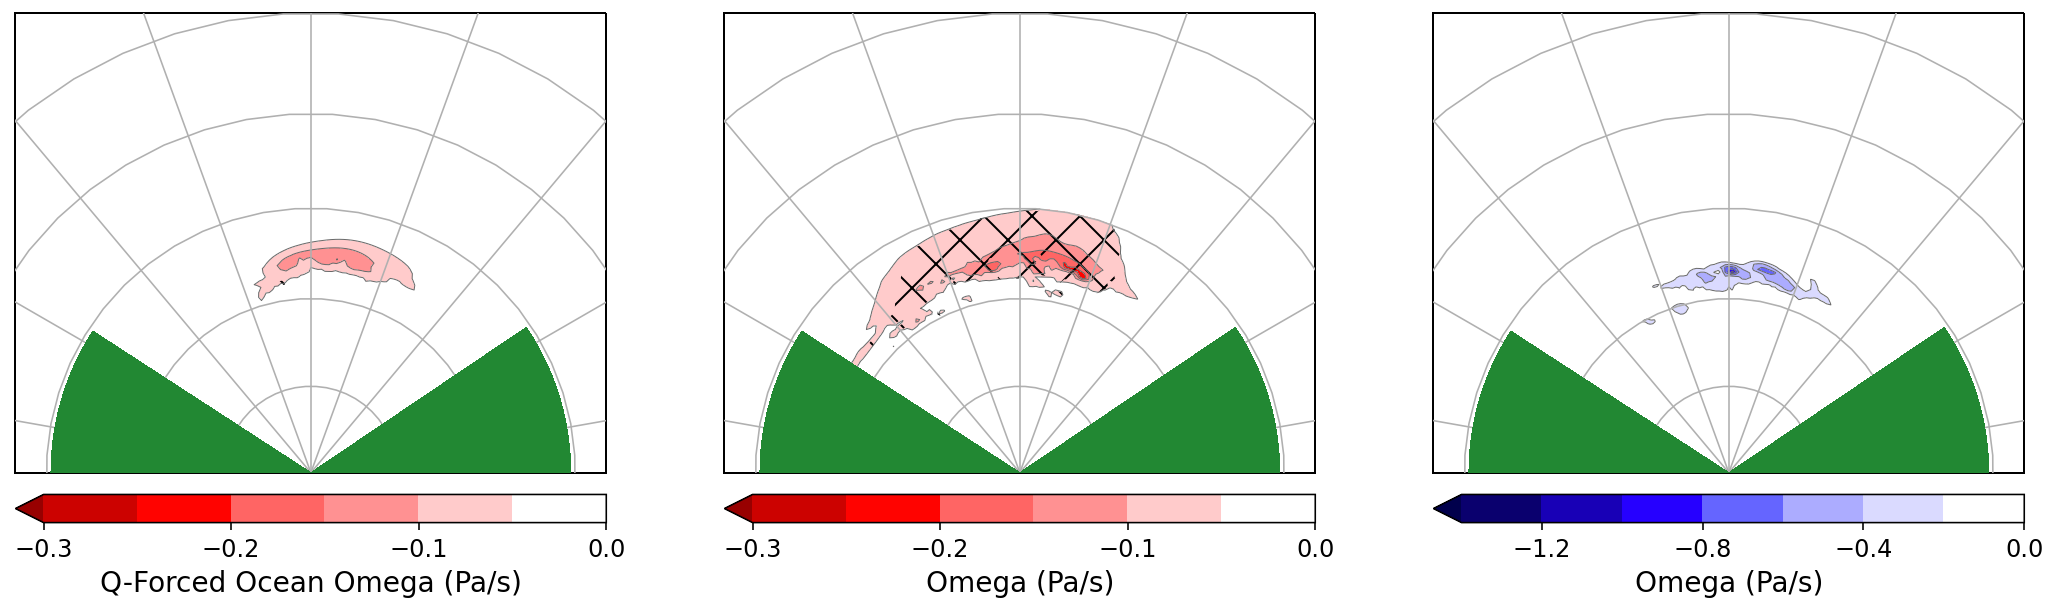

In [19]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18,10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
slice_data = basins.sel(lon  = slice(slice_start[r], slice_end[r]))
ax = axes.flatten()
for a in ax:
    a.set_extent([-40, 40, -90, -40], ccrs.PlateCarree())
    grid=a.gridlines(zorder = 20)
    grid.n_steps=30
    a.contourf(np.arange(-115,-56,1), np.arange(-90, -60, .5), np.ones((60, 59)), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), transform=ccrs.PlateCarree(), zorder = 25)
    a.contourf(np.arange(56,115,1), np.arange(-90, -60, .5), np.ones((60, 59)), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), transform=ccrs.PlateCarree(), zorder = 25)

levels_contour = np.arange(-.3,.025,.025)
cf = ax[0].contourf(np.arange(-115,115,1), Q_data.lat.values, np.nanmean(Q_data.Q_Omega, 0), levels = levels_contour, extend = 'min', colors = color_map[::-1][3:16], transform=ccrs.PlateCarree())
ax[0].contour(np.arange(-115,115,1), Q_data.lat.values, np.nanmean(Q_data.Q_Omega, 0), levels = np.arange(-.2,0,.05), linestyles = 'solid', linewidths = .5, colors = 'dimgrey', transform=ccrs.PlateCarree())

fig.colorbar(cf, ax = ax[0], orientation = 'horizontal', label = 'Q-Forced Ocean Omega (Pa/s)', pad = .02,
            ticks = [-.3, -.2, -.1,0, .1, .2,  .3])
    
    
    
levels_contour = np.arange(-.3,.025,.025)


cf = ax[1].contourf(np.arange(-115,115,1), Q_data.lat.values, np.nanmean(Q_data.Residual_Omega, 0), levels = levels_contour, extend = 'min', colors = color_map[::-1][3:16], transform=ccrs.PlateCarree())
ax[1].contour(np.arange(-115,115,1), Q_data.lat.values, np.nanmean(Q_data.Residual_Omega, 0), levels = np.arange(-.2,0,.05), linestyles = 'solid', linewidths = .5, colors = 'dimgrey', transform=ccrs.PlateCarree())

fig.colorbar(cf, ax = ax[1], orientation = 'horizontal', label = 'Omega (Pa/s)', pad = .02,
            ticks = [-.3, -.2, -.1,0, .1, .2,  .3])
   
ax[0].contourf(np.arange(-115,115,1), Q_data.lat.values, sig_Q,transform=ccrs.PlateCarree(),colors='none',levels=[.5, 1.5], hatches='x')
ax[1].contourf(np.arange(-115,115,1), Q_data.lat.values, sig_Resid,transform=ccrs.PlateCarree(),colors='none',levels=[.5, 1.5], hatches='x')

    
levels_contour = np.arange(-1.4, .1, .1)
cf = ax[2].contourf(np.arange(-115,115,1), basins.lat.values, -1*np.nanmean(shifted_lift, 0), colors = color_map[:15], levels = levels_contour,extend = 'min', transform=ccrs.PlateCarree())
ax[2].contour(np.arange(-115,115,1), basins.lat.values, -1*np.nanmean(shifted_lift, 0), levels = [-1.2, -1, -.8, -.6, -.4, -.2], linestyles = 'solid', linewidths = .5, colors = 'dimgrey', transform=ccrs.PlateCarree())

cbar = fig.colorbar(cf, ax = ax[2], orientation = 'horizontal', label = 'Omega (Pa/s)', pad = .02, ticks=[ -1.2, -.8, -.4, 0, .4, .8, 1.2])

# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/lift_comparison_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')
